In [94]:
import os
import sys

import matplotlib.pyplot as plt
from hydra import initialize, compose
from glob import glob
import pickle
import numpy as np
from tqdm import tqdm
from PIL import Image
import random

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses import lens_util
from mejiro.plots import plot
from mejiro.utils import util
from mejiro.helpers import color

In [95]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
debugging = False
if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

In [96]:
pipeline_params = util.hydra_to_dict(config.pipeline)
model_stretch = pipeline_params['rgb_stretch']
model_Q = pipeline_params['rgb_q']

In [107]:
color_images, color_model_images, lenses = [], [], []

for index in range(100):
    lens, rgb_model, rgb_image = lens_util.get_sample(pipeline_dir, index, model_stretch=0.05, model_Q=5)
    if lens.get_einstein_radius() > 0.5 and lens.snr > 25:
        color_images.append(rgb_image)
        color_model_images.append(rgb_model)
        lenses.append(lens)

In [108]:
subfigure_dir = os.path.join(config.machine.data_dir, 'figures', 'mosaic_pieces')
util.create_directory_if_not_exists(subfigure_dir)
util.clear_directory(subfigure_dir)

for idx, (model, image) in enumerate(zip(color_model_images, color_images)):
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(model)
    ax[1].imshow(image)
    for a in ax:
        a.axis('off')
        # a.margins(0,0)
        # a.xaxis.set_major_locator(plt.NullLocator())
        # a.yaxis.set_major_locator(plt.NullLocator())
    # ax[0].autoscale_view('tight')
    # ax[1].autoscale_view('tight')
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.savefig(os.path.join(subfigure_dir, f'{str(idx).zfill(3)}.png'), pad_inches=0)
    plt.close()

In [109]:
mosaic_pieces = [np.array(Image.open(f)) for f in glob(subfigure_dir + '/*.png')]

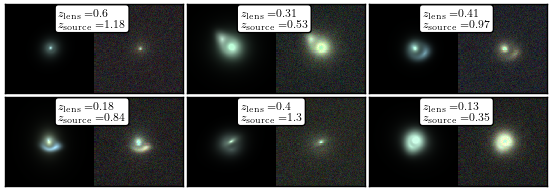

In [110]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(7, 3.5))  # figsize=(14, 14)

grid = ImageGrid(
    fig, 111,
    nrows_ncols=(2, 3),
    axes_pad=0.04,
    label_mode='all',
    share_all=True)

start_idx = 5
mosaic_pieces = mosaic_pieces[start_idx:]

# build captions
text_list = []
for lens in lenses[start_idx:]:
    caption = r'$z_{\textrm{lens}}=$' + str(round(lens.z_lens, 2)) + '\n' + r'$z_{\textrm{source}}=$' + str(round(lens.z_source, 2))
    text_list.append(caption)

props = dict(boxstyle='round', facecolor='w')  # , alpha=0.5

for i, ax in enumerate(grid):
    im = ax.imshow(mosaic_pieces[i])
    ax.text(0.3, 0.74, text_list[i], transform=ax.transAxes,
                  verticalalignment='baseline', bbox=props, fontsize=8)

grid.axes_llc.set(xticks=[], yticks=[])

save_path = os.path.join(figure_dir, 'mosaic.png')
plt.savefig(save_path)
plt.show()